# Estimating Correlated Uncertainty from Fitted Blowers-Masel Trees


## Overview

For each node in the kinetics rate rule family tree, we want to know how it depends on each training reaction.

<img src="new_trees.png" width="500">

## Computing Sensitivity

Sensitivity S is the relative change in output $y$ over a given relative change in input $x$:
$$S = \frac{\frac{dy}{y}}{\frac{dx}{x}} = \frac{\frac{y_{perturbed} - y}{y}}{\frac{x_{perturbed} - x}{x}} $$

$$S = \frac{dy}{dx}\cdot \frac{x}{y} $$

Define the scale factor $a$:
$$x_{perturbed} = ax$$

$$x_{perturbed} = (a-1)x + x$$

$$x_{perturbed} - x = (a-1)x$$

$$\frac{x_{perturbed} - x}{x} = a - 1$$

$$\frac{dx}{x} = a - 1$$

$$S = \frac{\frac{dy}{y}}{a - 1}$$

$$S = \frac{d\ln(y)}{a - 1}$$

# Generate the family tree

In [1]:
## Imports

import json

from rmgpy.molecule.molecule import *
from rmgpy.species import *
from rmgpy.data.rmg import RMGDatabase
from rmgpy.species import Species
from rmgpy import settings

import rmgpy
from rmgpy import chemkin
import numpy as np
from copy import deepcopy
import csv
from rmgpy.molecule.molecule import *
from rmgpy.species import *
from rmgpy.chemkin import *
import rmgpy.kinetics as _kinetics
from rmgpy.data.rmg import RMGDatabase
from IPython.display import display
from rmgpy.data.thermo import ThermoLibrary
from rmgpy.rmg.react import react
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.data.rmg import get_db
from rmgpy.exceptions import UndeterminableKineticsError, ActionError
from rmgpy.data.base import LogicOr
from itertools import product
from rmgpy.molecule.group import Group
from rmgpy.kinetics.arrhenius import ArrheniusBM
import time
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [2]:
## Load the database
database = RMGDatabase()
database.load(path=settings['database.directory'],
              thermo_libraries=['Klippenstein_Glarborg2016', 'BurkeH2O2', 'thermo_DFT_CCSDTF12_BAC',
                                'DFT_QCI_thermo', 'primaryThermoLibrary', 'primaryNS', 'NitrogenCurran',
                                'NOx2018', 'FFCM1(-)', 'SulfurLibrary', 'SulfurGlarborgH2S', 'SABIC_aromatics'],
              transport_libraries=[],
              reaction_libraries=[],
              seed_mechanisms=[],  # ['BurkeH2O2inN2','ERC-FoundationFuelv0.9'],
              kinetics_families= ['Singlet_Carbene_Intra_Disproportionation'], # 'all'
              kinetics_depositories=['training'],
              depository=False,  # Don't bother loading the depository information, as we don't use it
              )

In [3]:
## Make the kinetics rate rule tree

family = database.kinetics.families["Singlet_Carbene_Intra_Disproportionation"]
family.clean_tree()

family.generate_tree(thermo_database=database.thermo,
                     nprocs=1,
                     new_fraction_threshold_to_reopt_node=0.25,
                     max_batch_size=800,
                     extension_iter_max=2,
                     extension_iter_item_cap=100)

print(f"Group Entries: {len(family.groups.entries)}")
family.check_tree()
family.regularize(thermo_database=database.thermo)
templateRxnMap = family.get_reaction_matches(thermo_database=database.thermo, remove_degeneracy=True,
                                             get_reverse=True, exact_matches_only=False, fix_labels=True)


ERROR:root:4.0
ERROR:root:iter_max achieved terminating early
ERROR:root:iter_max achieved terminating early
ERROR:root:iter_max achieved terminating early


Group Entries: 7


## Fit nodes to training reactions and compute sensitivites

In [4]:
family.clean_tree_rules()
family.make_bm_rules_from_template_rxn_map(templateRxnMap, compute_derivatives=True)

/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/moon/rmg/RMG-Py/rmgpy/data/kinetics/family.py:4740: RuntimeWarning: invalid value encountered in log
  sensitivity_E0_only = (np.log(kin_perturbed_onlyE0.E0.value_si) - np.log(kin.E0.value_si)) / (SCALE_FACTOR - 1)


In [5]:
## unpack the sensitivites from the long description
derivatives = {}
for key in family.rules.entries.keys():
    entry = family.rules.entries[key]
    
    if len(entry) == 0:
        derivatives[key] = []
        continue
    entry = entry[0]
    # print(entry.long_desc)
    start_str = 'sensitivities = '
    start_index = entry.long_desc.find(start_str) + len(start_str)
    sensitivities_str = entry.long_desc[start_index:].replace("'", '"')
    sensitivities_str = sensitivities_str.replace("nan", '"-9999999"')
    # print(sensitivities_str)
    derivatives[key] = json.loads(sensitivities_str)

In [6]:
family.rules.entries['Root'][0].index

1

In [15]:
## Try to visualize the tree
print(family.groups.entries['Root'].index, family.rules.entries['Root'][0])
for child in family.groups.entries['Root'].children:
    print(child.index, "\t", child)
    for grandchild in child.children:
        print(grandchild.index, "\t\t", grandchild)
        for greatgrandchild in grandchild.children:
            print(greatgrandchild.index, "\t\t\t", greatgrandchild)

            


0 Root
1 	 Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C
3 		 Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C_Ext-4R!H-R_Ext-4R!H-R
2 	 Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C
4 		 Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_Sp-6R!H-5R!H
5 		 Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-6R!H-5R!H


### Singlet_Carbene_Intra_Disproportionation
<img src="labeled_nodes.png" width="250">

In [46]:
# list the training reactions
print('Normalized Sensitivities with freely varying partial derivatives\n')
print('# Node\tTraining Reaction\t\tdA_node/dA_train\tdE0_node/dA_train\tdn_node/dA_train')

for key in family.rules.entries.keys():
    entry = family.rules.entries[key]
    group_index = family.groups.entries[key].index
    if len(entry) == 0:
        continue
    print(group_index, entry[0])
    for i, rxn in enumerate(templateRxnMap[key]):
        N = 25
        pad_length = N - len(str(rxn))
        rxn_str = str(rxn) + " " * pad_length        
        print('\t', rxn_str, "\t\t{0:.6f}".format(derivatives[key][i]['dA']), "\t\t{0:.6f}".format(derivatives[key][i]['dE0']), "\t\t{0:.6f}".format(derivatives[key][i]['dn'])) # derivatives[key][i]['name'])
        
    print()

Normalized Sensitivities with freely varying partial derivatives

# Node	Training Reaction		dA_node/dA_train	dE0_node/dA_train	dn_node/dA_train
0 Root
	 C6H6 <=> C6H6-2           		1.844369 		0.016316 		0.104084
	 C6H6-3 <=> C6H6-4         		10.106165 		0.100870 		0.643379
	 [C]1C=CC=CC1 <=> C6H6-5   		-6.721413 		-0.071365 		-0.455045
	 [C]1C=CCC=C1 <=> C6H6-7   		-4.178835 		-0.045337 		-0.289080

1 Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C
	 C6H6 <=> C6H6-2           		0.500646 		0.000000 		-0.000044
	 C6H6-3 <=> C6H6-4         		0.499933 		0.000000 		-0.000009

2 Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C
	 [C]1C=CC=CC1 <=> C6H6-5   		0.499719 		-0.000000 		0.000001
	 [C]1C=CCC=C1 <=> C6H6-7   		0.500194 		-0.000000 		-0.000009

3 Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C_Ext-4R!H-R_Ext-4R!H-R
	 C6H6 <=> C6H6-2           		0.999500 		0.000000 		0.000000

4 Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_Sp-6R!H-5R!H
	 [C]1C=CC=CC1 <=> C6H6-5   		0.999500 		0.000000 		-0.00000

In [51]:
# list the training reactions
print('Normalized Sensitivities with fixed partial derivatives\n')
print('# Node\tTraining Reaction\t\tdA_node/dA_train\tdE0_node/dA_train\tdn_node/dA_train')

for key in family.rules.entries.keys():
    entry = family.rules.entries[key]
    group_index = family.groups.entries[key].index
    if len(entry) == 0:
        continue
    print(group_index, entry[0])
    for i, rxn in enumerate(templateRxnMap[key]):
        N = 25
        pad_length = N - len(str(rxn))
        rxn_str = str(rxn) + " " * pad_length
        print('\t', rxn_str, "\t\t{0:.6f}".format(derivatives[key][i]['dA_only']), "\t\t{0:.6f}".format(float(derivatives[key][i]['dE0_only'])))
        
    print()

Normalized Sensitivities with fixed partial derivatives

# Node	Training Reaction		dA_node/dA_train	dE0_node/dA_train	dn_node/dA_train
0 Root
	 C6H6 <=> C6H6-2           		0.249876 		-0.018013
	 C6H6-3 <=> C6H6-4         		0.249876 		-0.010901
	 [C]1C=CC=CC1 <=> C6H6-5   		0.249876 		-0.025401
	 [C]1C=CCC=C1 <=> C6H6-7   		0.249876 		-0.023209

1 Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C
	 C6H6 <=> C6H6-2           		0.499753 		0.000000
	 C6H6-3 <=> C6H6-4         		0.499752 		0.000000

2 Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C
	 [C]1C=CC=CC1 <=> C6H6-5   		0.499750 		-9999999.000000
	 [C]1C=CCC=C1 <=> C6H6-7   		0.499751 		-9999999.000000

3 Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C_Ext-4R!H-R_Ext-4R!H-R
	 C6H6 <=> C6H6-2           		0.999500 		0.000000

4 Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_Sp-6R!H-5R!H
	 [C]1C=CC=CC1 <=> C6H6-5   		0.999500 		0.000000

5 Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-6R!H-5R!H
	 [C]1C=CCC=C1 <=> C6H6

## Try to visualize the fitting

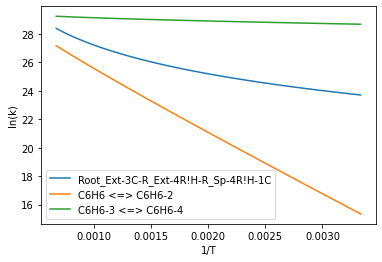

In [59]:
## Compare Arrhenius plot [ln(k) vs 1/T] for node to training reactions

import matplotlib.pyplot as plt


# Pick a node to plot
# node_name = 'Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-6R!H-5R!H'  # one training reaction
node_name = 'Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C'  # two training reactions
# node_name = 'Root'  # four training reactions


Tmin = 300
Tmax = 1500
legend = []

    
def estimate_delta_H(T):
    dH = 0
    for j, training_rxn in enumerate(templateRxnMap[node_name]):
        dH += training_rxn.get_enthalpy_of_reaction(T)
    return dH / float(len(templateRxnMap[node_name]))


# plot the node's ln(k)
legend.append(node_name)
T = np.linspace(Tmin, Tmax, 100)
T_inv = 1.0 / T
lnk = np.zeros(len(T))
for i, Temp in enumerate(T):
    delta_h = estimate_delta_H(Temp)
    # delta_h = estimate_delta_H(1000)
    lnk[i] = np.log(family.rules.entries[node_name][0].data.get_rate_coefficient(Temp, dHrxn=delta_h))
plt.plot(T_inv, lnk)
# print(family.rules.entries[node_name][0].data)


# Plot each training reaction's ln(k)
for training_rxn in templateRxnMap[node_name]:
    legend.append(str(training_rxn))
    for i, Temp in enumerate(T):
        lnk[i] = np.log(training_rxn.kinetics.get_rate_coefficient(Temp))
    # print(training_rxn.kinetics)
    plt.plot(T_inv, lnk)


plt.ylabel('ln(k)')
plt.xlabel('1/T')
plt.legend(legend)
plt.show()

In [ ]:
# node kinetics

# dir(family.rules.entries[node_name][0].item)

T = 300
P = 1013250
training_rxn.kinetics.get_rate_coefficient(T)


In [ ]:
family.rules.entries['Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C'][0].data

In [ ]:
print(type(family.rules.entries[node_name][0].data))
dir(family.groups.entries[node_name].item)

In [ ]:
templateRxnMap['Root'][1]

In [ ]:
family.rules.entries

In [ ]:
family.groups.entries['Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C'].item

In [ ]:
# copied from branch     https://github.com/ReactionMechanismGenerator/RMG-database/blob/singlet-carbene-intra-d_tree/input/kinetics/families/Singlet_Carbene_Intra_Disproportionation/groups.py

tree(
"""
L1: Root
    L2: Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C
        L3: Root_Ext-3C-R_Ext-4R!H-R_Sp-4R!H-1C_Ext-4R!H-R_Ext-4R!H-R
    L2: Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C
        L3: Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_Sp-6R!H-5R!H
        L3: Root_Ext-3C-R_Ext-4R!H-R_N-Sp-4R!H-1C_Ext-4R!H-R_Ext-5R!H-R_Ext-5R!H-R_N-Sp-6R!H-5R!H
"""
)